In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../")
import hmrf_gmm

# 1-D Example Data

## Create Model

In [2]:
phys_space = np.random.randn(500,1)
feat_space = np.random.randn(500,3)

# np.random.seed(12345)
# define domain
latent_1D = np.zeros_like(phys_space[:,0])
dist = scipy.stats.bernoulli(0.01)
dist2 = scipy.stats.bernoulli(0.45)

In [3]:
val = 0
for i in range(len(phys_space[:,0])):
    if dist.rvs():
        if  dist2.rvs():
            val = 2 - val
        else:
            val = 1 - val
    latent_1D[i] = val

In [4]:
latent_1D = np.ones(25)*2
latent_1D = np.append(latent_1D, np.ones(75)*0)
latent_1D = np.append(latent_1D, np.ones(100)*1)
latent_1D = np.append(latent_1D, np.ones(50)*2)
latent_1D = np.append(latent_1D, np.ones(25)*1)
latent_1D = np.append(latent_1D, np.ones(25)*2)
latent_1D = np.append(latent_1D, np.ones(100)*0)
latent_1D = np.append(latent_1D, np.ones(100)*2)

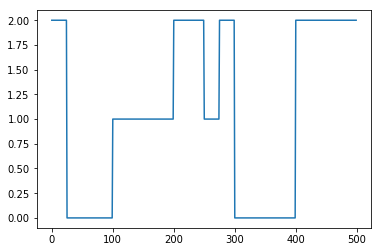

In [5]:
plt.plot(latent_1D);

In [69]:
i = 4
c1 = scipy.stats.multivariate_normal([7,9,10,2.7], np.eye(i)*0.35)
c2 = scipy.stats.multivariate_normal([8,8,9.5,2], np.eye(i)*0.55)
c3 = scipy.stats.multivariate_normal([8,9,9,1.5], np.eye(i)*0.25)
#c4 = scipy.stats.multivariate_normal([8,10,9,4], np.eye(i)*0.25)

In [79]:
ex1.gmm.means_

array([[ 6.90270878,  9.01142701,  9.96493944,  2.63981953],
       [ 7.96401156,  7.94253056,  9.49166253,  2.15359216],
       [ 7.98799955,  8.97612273,  9.10089553,  1.42730163]])

In [86]:
ex1.gmm.means_ - np.average(ex1.mus, axis=0)

array([[-0.07027543,  0.04004744, -0.01242617,  0.01812779],
       [ 0.01087886, -0.03244967, -0.0347416 ,  0.11576208],
       [ 0.00734804,  0.0218617 ,  0.05647546, -0.00773771]])

In [85]:
np.average(ex1.mus, axis=0)

array([[ 6.97298421,  8.97137958,  9.97736561,  2.62169174],
       [ 7.9531327 ,  7.97498024,  9.52640413,  2.03783008],
       [ 7.9806515 ,  8.95426103,  9.04442007,  1.43503934]])

## Sample Data

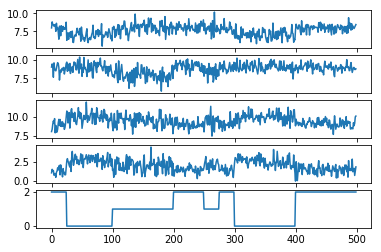

In [70]:
obs = np.empty((len(phys_space[:,0]), 4))

for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        obs[i,:] = c1.rvs()
    elif l == 1:
        obs[i,:] = c2.rvs()
    elif l == 2:
        obs[i,:] = c3.rvs()
        
fig, ax = plt.subplots(5,1)
ax[0].plot(obs[:,0])
ax[1].plot(obs[:,1])
ax[2].plot(obs[:,2])
ax[3].plot(obs[:,3])
ax[4].plot(latent_1D)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


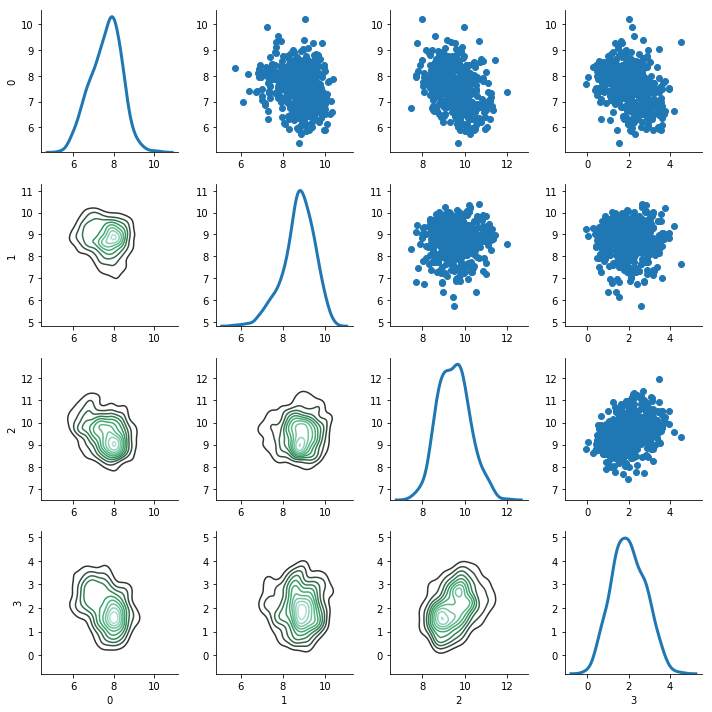

In [71]:
import seaborn as sns
df = pd.DataFrame(obs)

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

plt.tight_layout()
#plt.savefig("features.png")

In [73]:
def find_correct_labels(gmm, obs, verbose=True):
    """Create look-up table for which label of the GMM belongs to which label in the observations."""
    gmm_means = np.mean(gmm.means_, axis=0)
    obs_means = np.mean(obs, axis=0)
    if verbose:
        print("mean gmm:", gmm_means)
        print("mean obs:", obs_means)
    
    lot = {}
    for o in range(len(obs[1])):
        lot[o] = np.argmin(np.abs(a[o]-b))
        
    return lot

In [78]:
find_correct_labels(ex1.gmm, obs)

mean gmm: [ 7.61823996  8.6433601   9.51916583  2.07357111]
mean obs: [ 7.61430093  8.74595431  9.48548389  2.00867961]


{0: 0, 1: 1, 2: 2, 3: 3}

In [72]:
ex1 = hmrf_gmm.HMRFGMM(phys_space, obs, n_labels=3, beta_init=10)

In [75]:
ex1.fit(75, beta_jump_length=10, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [06:43<00:00,  5.38s/it]


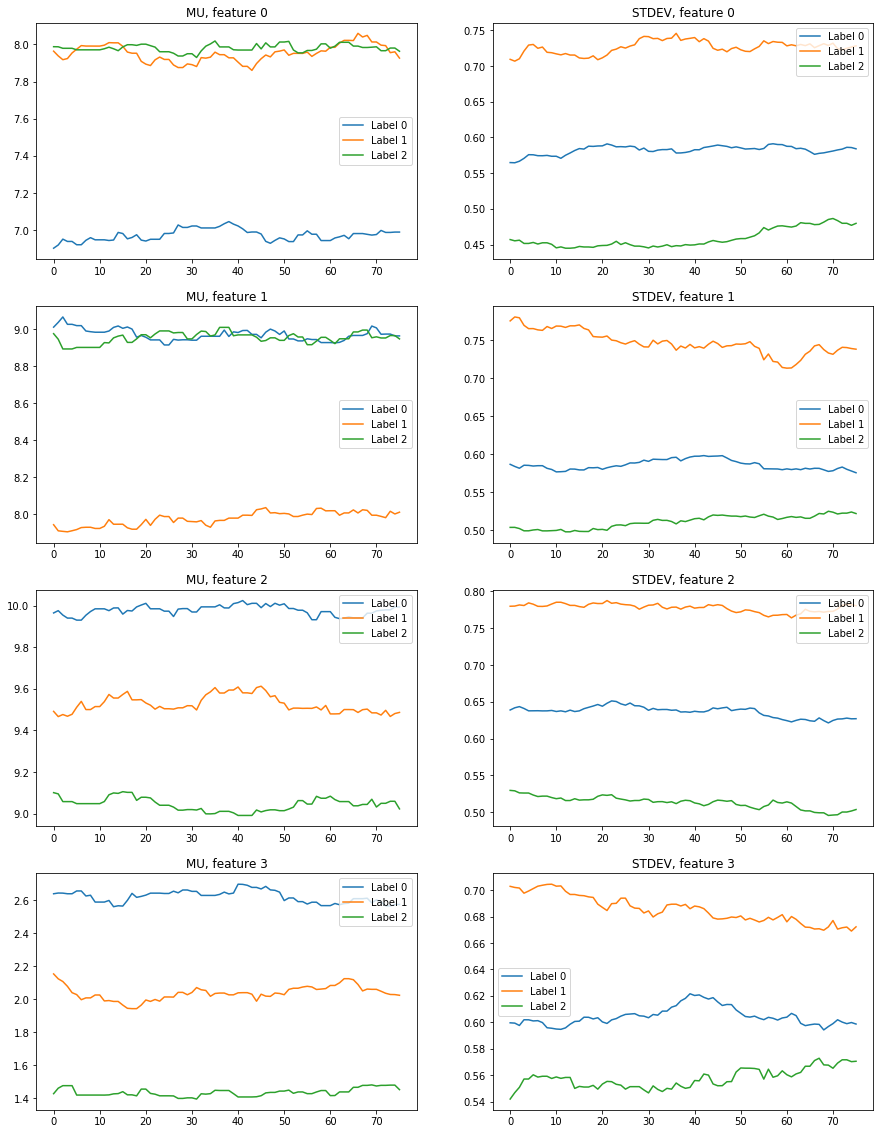

In [76]:
ex1.plot_mu_cov()
# ex1.plot_mu_stdev()
# plt.tight_layout()
# plt.savefig("mu_stdev.png")

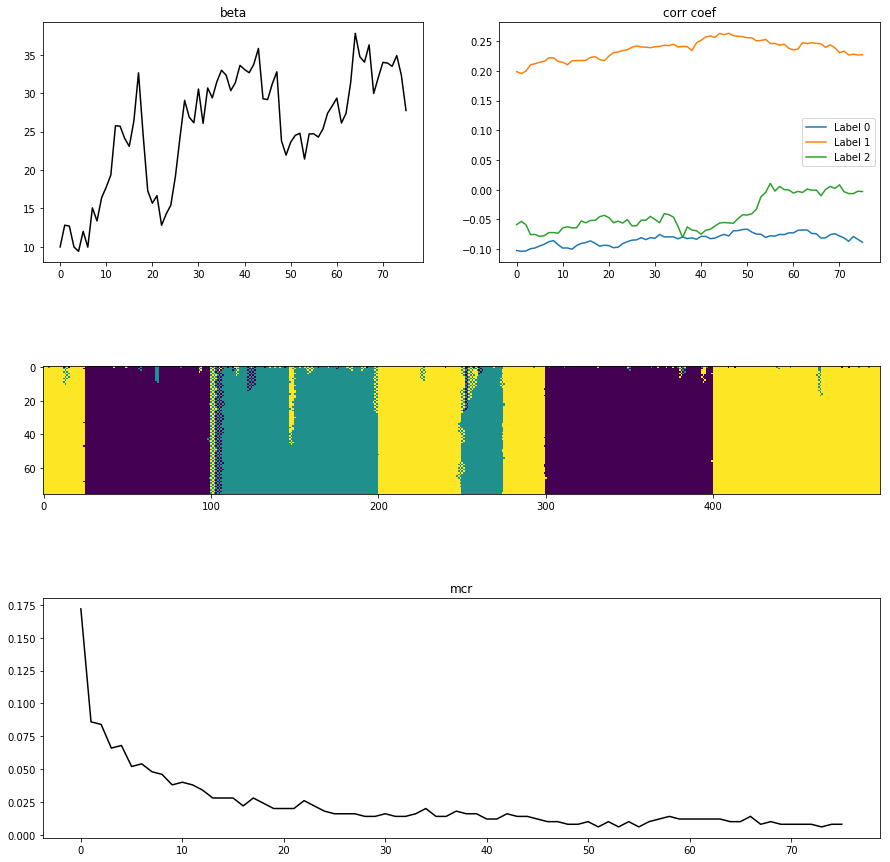

In [77]:
ex1.diagnostics_plot(true_labels=latent_1D)
#plt.tight_layout()
#plt.savefig("diagn.png")

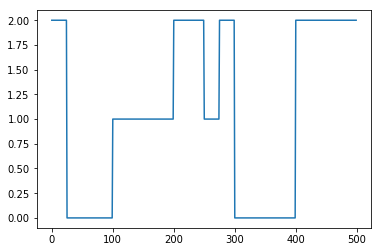

In [18]:
plt.plot(latent_1D)

In [431]:
import numpy as np
from sklearn import mixture
from scipy.stats import multivariate_normal, norm
from copy import copy
from itertools import combinations
import tqdm  # progress bar
import matplotlib.pyplot as plt
from matplotlib import gridspec  # plot arrangements

# VECTORIZE

In [448]:
comp_coef = np.ones((500,3))

In [654]:
%%timeit
calc_sum_log_mixture_density(ex1, comp_coef, ex1.mus[-1], ex1.covs[-1])

381 ms ± 6.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


377 ms ± 8.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
multivariate_normal(mean=mu[l, :], cov=cov[l, :, :]).pdf(self.obs)

In [656]:
def calc_sum_log_mixture_density_vect(self, comp_coef, mu, cov):
    lmd = np.zeros((500,3))
    
    for l in range(self.n_labels):
        lmd[:,l] = multivariate_normal(mean=mu[l, :], cov=cov[l, :, :]).pdf(self.obs)
        #print(np.shape(lmd[:,l]))
        #multi = comp_coef[:,l] * draw
        #lmd[:,l] = np.log(multi)
    lmd = np.sum(lmd, axis=1)
    lmd = np.log(lmd)
    
    return np.sum(lmd)#np.sum(np.sum(lmd, axis=1))

In [657]:
%%timeit
calc_sum_log_mixture_density_vect(ex1, comp_coef, ex1.mus[-1], ex1.covs[-1])

930 µs ± 97.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [469]:
ex1.obs

array([[  7.95726105,   9.02216298,   8.0645653 ,   1.05495449],
       [  8.80943865,   9.45107943,   8.36356179,   1.5278245 ],
       [  8.42678553,   9.00381201,   9.0374482 ,   1.30500651],
       ..., 
       [  8.06641104,   8.69669335,   9.17973381,   0.70574948],
       [  8.26158962,   8.68606534,  10.01402118,   1.27104371],
       [  8.43087245,   8.77365571,  10.11548147,   1.85574354]])

In [652]:
def calc_sum_log_mixture_density(self, comp_coef, mu, cov):
    """
    Calculate sum of log mixture density with each observation at every element.
    :param comp_coef: Component coefficient.
    :param mu: Mean matrix
    :param cov: Covariance matrix
    :return: summed log mixture density of the system
    """
    if self.dim == 1:
        lmd = 0.

        for x in range(len(self.coords)):
            # print("observation", x)
            storage2 = []
            for l in range(self.n_labels):
                #print(self.obs[x])
                draw = multivariate_normal(mean=mu[l, :], cov=cov[l, :, :]).pdf(self.obs[x])
                #print(draw)
                # print(b)
                a = comp_coef[x, l] * draw
                # print(a)
                storage2.append(a)
            # print(storage2)

            lmd += (np.log(np.sum(storage2)))

    else:
        pass
    # TODO: 2-dimensional log mixture density
    # TODO: 3-dimensional log mixture density

    return lmd

In [352]:
ex1.calc_gibbs_energy(ex1.labels[-1], 0.5)

array([[ 0.5,  0.5,  0. ],
       [ 1. ,  1. ,  0. ],
       [ 1. ,  1. ,  0. ],
       ..., 
       [ 1. ,  1. ,  0. ],
       [ 1. ,  1. ,  0. ],
       [ 0.5,  0.5,  0. ]])

In [115]:
# get neighbor indices
ni = np.array(ex1.neighborhood[100])

In [122]:
labels = np.array(list(range(ex1.n_labels)))
labels

array([0, 1, 2])

In [233]:
neighborhood = define_neighborhood_system(ex1.coords)

In [234]:
neighborhood[25]

array([ 24.,  26.])

In [261]:
labels = ex1.labels[-1]

In [417]:
n1_labels = ex1.labels[-1][neighborhood[1:-1,0].astype("int64")]
n2_labels = ex1.labels[-1][neighborhood[1:-1,1].astype("int64")]

neighboring_labels = np.stack([n1_labels, n2_labels], axis=1)

g = np.zeros((500,3))

for l in range(3):
    g[1:-1,l] = np.sum(np.equal(neighboring_labels, 1), axis=1) * beta

In [415]:
g[0, ex1.labels[-1][neighborhood[0,0].astype("int64")]]

0.0

In [302]:
g = np.zeros((498,3))
g[:,1] = 1
g[:,2] = 2

In [357]:
g[0, ex1.labels[-1][neighborhood[0,0].astype("int64")]]

1.5

In [356]:
gibbs_energy

array([[ 0. ,  0. ,  1.5],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1. ],
       ..., 
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1.5]])

In [355]:
gibbs_energy = calc_gibbs_energy_vect(ex1, ex1.labels[-1], 0.5)

# COV PROPOSAL TESTS

In [18]:
0.45**(1/2)

0.6708203932499369

In [38]:
cov = np.array([[[  1.99561992e+01 , -1.45150996e+00 , -2.63756395e+00  , 6.96056263e+00,    -1.01622760e+00],
  [ -1.45150996e+00 ,  1.17306877e-01  , 1.34722716e-01 , -6.38203391e-01,     8.36635998e-02],
  [ -2.63756395e+00 ,  1.34722716e-01 ,  6.40140987e+00 ,  1.07719128e+00,     2.09006538e-01],
  [  6.96056263e+00,  -6.38203391e-01 ,  1.07719128e+00 ,  4.75785818e+00,    -5.04168206e-01],
  [ -1.01622760e+00 ,  8.36635998e-02 ,  2.09006538e-01  ,-5.04168206e-01,     1.21996211e-01]]])

In [39]:
np.shape(cov)

(1, 5, 5)

In [ ]:
c1 = scipy.stats.multivariate_normal([6,9,10], np.eye(3)*0.25)
c2 = scipy.stats.multivariate_normal([8,8,11], np.eye(3)*0.15)
c3 = scipy.stats.multivariate_normal([8,11,9], np.eye(3)*0.35)

In [55]:
0.25**(1/2)

0.5

In [32]:
cov = np.array([[[ 1.70240204,  0.13019169,  0.26507972, -0.05779667],
 [ 0.13019169,  1.70098472, -0.06757848,  0.07736503],
 [ 0.26507972, -0.06757848,  1.60775912, -0.22083958],
 [-0.05779667 , 0.07736503, -0.22083958,  1.99746643]]])

In [33]:
np.shape(cov)

(1, 4, 4)

In [33]:
np.linalg.svd(cov[0, :, :])

(array([[-0.34658954,  0.68413653,  0.25486621, -0.58896189],
        [ 0.10536204,  0.58889702, -0.74277933,  0.30062935],
        [-0.48871925,  0.23117566,  0.41103607,  0.73400317],
        [ 0.79368005,  0.36292605,  0.46300262,  0.15487163]]),
 array([ 2.16896074,  1.87338189,  1.64548441,  1.32078527]),
 array([[-0.34658954,  0.10536204, -0.48871925,  0.79368005],
        [ 0.68413653,  0.58889702,  0.23117566,  0.36292605],
        [ 0.25486621, -0.74277933,  0.41103607,  0.46300262],
        [-0.58896189,  0.30062935,  0.73400317,  0.15487163]]))

In [47]:
cov = np.array([[[ 3.,  0.2,  0.3],
       [ 0.2,  2.,  0.6],
       [ 0.3,  0.6,  4.]]])

In [48]:
np.shape(cov)

(1, 3, 3)

In [49]:
covdiff = cov - propose_cov(cov, 3,1, 0.00005, 0.0005)
covdiff

 shp v_l: (3, 3)
 shp d_l: (3,)


array([[[-0.00590155,  0.03395092,  0.03608643],
        [ 0.03395092, -0.00803107, -0.00943427],
        [ 0.03608643, -0.00943427,  0.00324243]]])

In [24]:
from itertools import combinations
from scipy.stats import multivariate_normal

In [50]:
cov = np.array([[[ 1.70240204,  0.13019169,  0.26507972, -0.05779667],
 [ 0.13019169,  1.70098472, -0.06757848,  0.07736503],
 [ 0.26507972, -0.06757848,  1.60775912, -0.22083958],
 [-0.05779667 , 0.07736503, -0.22083958,  1.99746643]]])

covdiff = cov - propose_cov(cov, 4,1, 0.00005, 0.0005)
covdiff

 shp v_l: (4, 4)
 shp d_l: (4,)


array([[[-0.00331711, -0.01200307, -0.00910957, -0.00063114],
        [-0.01200307, -0.00658348, -0.00219675, -0.00707097],
        [-0.00910957, -0.00219675, -0.00494187, -0.01065656],
        [-0.00063114, -0.00707097, -0.01065656,  0.01388612]]])

In [61]:
cov = np.array([[[  1.99561992e+01 , -1.45150996e+00 , -2.63756395e+00  , 6.96056263e+00,    -1.01622760e+00],
  [ -1.45150996e+00 ,  1.17306877e-01  , 1.34722716e-01 , -6.38203391e-01,     8.36635998e-02],
  [ -2.63756395e+00 ,  1.34722716e-01 ,  6.40140987e+00 ,  1.07719128e+00,     2.09006538e-01],
  [  6.96056263e+00,  -6.38203391e-01 ,  1.07719128e+00 ,  4.75785818e+00,    -5.04168206e-01],
  [ -1.01622760e+00 ,  8.36635998e-02 ,  2.09006538e-01  ,-5.04168206e-01,     1.21996211e-01]]])

covdiff = cov - propose_cov(cov, 5,1, 0.000000005, 0.00000005)
covdiff

 shp v_l: (5, 5)
 shp d_l: (5,)


array([[[ -1.32504532e-03,  -3.31717970e-03,   1.94099542e-03,
           3.16929509e-04,   1.27308342e-03],
        [ -3.31717970e-03,   4.97891541e-04,  -3.76669214e-04,
          -1.40158481e-03,   9.95005537e-05],
        [  1.94099542e-03,  -3.76669214e-04,   1.46475731e-03,
          -2.43689538e-04,  -3.20029701e-03],
        [  3.16929509e-04,  -1.40158481e-03,  -2.43689538e-04,
          -2.56884675e-04,  -6.19464331e-04],
        [  1.27308342e-03,   9.95005537e-05,  -3.20029701e-03,
          -6.19464331e-04,  -1.91775455e-04]]])

In [56]:
cov = np.array([[[ 3.,  0.2,  0.3,  0.4,  0.6],
         [ 0.2,  4.,  0.3,  0.5,  0.2],
         [ 0.3,  0.3,  6.,  0.7,  1.],
         [ 0.4,  0.5,  0.7,  2.,  0.4],
         [ 0.6,  0.2,  1.,  0.4,  3.]]])

covdiff = cov - propose_cov(cov, 5,1, 0.00005, 0.0005)
covdiff

 shp v_l: (5, 5)
 shp d_l: (5,)


array([[[ 0.00402245,  0.00542103,  0.07907599,  0.03555844,  0.02765139],
        [ 0.00542103, -0.0607357 , -0.10522585, -0.050517  , -0.02679857],
        [ 0.07907599, -0.10522585, -0.04996802,  0.00120204,  0.08723668],
        [ 0.03555844, -0.050517  ,  0.00120204, -0.0097601 ,  0.04280319],
        [ 0.02765139, -0.02679857,  0.08723668,  0.04280319,  0.09737256]]])

In [41]:
def _cov_proposal_rotation_matrix(x, y, theta):
    """

    :param x, y: two base vectors defining a plane
    :param theta: rotation angle in this plane
    :return: rotation matrix for covariance proposal step
    """
    x = np.array([x]).T
    y = np.array([y]).T

    uu = x / np.linalg.norm(x)
    vv = y - uu.T @ y * uu
    vv = vv / np.linalg.norm(vv)
    # what is happening

    # rotation_matrix = np.eye(len(x)) - np.matmul(uu, uu.T) - np.matmul(np.matmul(vv, vv.T) + np.matmul(np.hstack((uu, vv)), np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])), np.hstack((uu, vv)).T)
    rotation_matrix = np.eye(len(x)) - uu @ uu.T - vv @ vv.T + np.hstack((uu, vv)) @ np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) @ np.hstack((uu, vv)).T
    return rotation_matrix

In [23]:
def propose_cov(cov_prev, n_feat, n_labels, cov_jump_length, theta_jump_length):
    """

    :param cov_prev:
    :param cov_jump_length:
    :param theta_jump_length:
    :return:
    """
    # do svd on the previous covariance matrix
    comb = list(combinations(range(n_feat), 2))
    n_comb = len(comb)
    theta_jump = multivariate_normal(mean=[0 for i in range(n_comb)], cov=np.ones(n_comb) * theta_jump_length).rvs()
    cov_prop = np.zeros_like(cov_prev)

    # print("cov_prev:", cov_prev)

    for l in range(n_labels):

        v_l, d_l, v_l_t = np.linalg.svd(cov_prev[l, :, :])
        print(" shp v_l:", np.shape(v_l))
        print(" shp d_l:", np.shape(d_l))
        # generate d jump
        log_d_jump = multivariate_normal(mean=[0 for i in range(n_feat)], cov=np.eye(n_feat) * cov_jump_length).rvs()
        # sum towards d proposal
        # if l == 0:
        d_prop = np.diag(np.exp(np.log(d_l) + log_d_jump))
        # else:
        #    d_prop = np.vstack((d_prop, np.exp(np.log(d_l) + np.log(d_jump))))

        # now tackle generating v jump
        a = np.eye(n_feat)
        # print("a init:", a)
        # print("shape a:", np.shape(a))
        for j in range(n_comb):
            rotation_matrix = _cov_proposal_rotation_matrix(v_l[:, comb[j][0]], v_l[:, comb[j][1]], theta_jump[j])
            # print("rot mat:", rotation_matrix)
            # print("rot mat:", rotation_matrix)
            a = rotation_matrix @ a
            # print("a:", a)
        # print("v_l:", np.shape(v_l))
        v_prop = a @ v_l  # np.matmul(a, v_l)
        # print("d_prop:", d_prop)
        # print("v_prop:", np.shape(v_prop))
        # TODO: Is this proposal covariance slicing correct?
        cov_prop[l, :, :] = v_prop @ d_prop @ v_prop.T  # np.matmul(np.matmul(v_prop, d_prop), v_prop.T)
        # print("cov_prop:", cov_prop)

    return cov_prop

In [80]:
import sys
for i in range(200):
    sys.stdout.write(str(i))
    sys.stdout.write('\r')
    sys.stdout.flush()